In [1]:
import numpy as np
import pandas as pd

import random
random.seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv(
    r"C:\Users\HP\Text-Based-Risk-Classification-System\Text-Based-Risk-Classification-System\data\spam.csv",
    encoding="latin-1"
)


df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})

df = df.drop_duplicates().reset_index(drop=True)


In [4]:
# basic length features
df['message_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

# numeric-related features
df['number_count'] = df['text'].str.count(r'\d+')
df['contains_number'] = (df['number_count'] > 0).astype(int)

# special characters
df['special_char_count'] = df['text'].str.count(r'[^\w\s]')

# url indicator
df['has_url'] = df['text'].str.contains(r'http|www', regex=True).astype(int)


In [5]:
df['text_model'] = df['text'].str.lower()


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

X_train_text = tfidf.fit_transform(X_train['text_model'])
X_test_text  = tfidf.transform(X_test['text_model'])



In [12]:

from sklearn.preprocessing import StandardScaler

num_features = [
    'message_length',
    'word_count',
    'number_count',
    'contains_number',
    'special_char_count',
    'has_url'
]

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num  = scaler.transform(X_test[num_features])

In [13]:
from scipy.sparse import hstack

X_train_final = hstack([X_train_text, X_train_num])
X_test_final  = hstack([X_test_text, X_test_num])


In [28]:
from sklearn.linear_model import LogisticRegression

lr_base = LogisticRegression(
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)


In [29]:
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}


In [ ]:
from sklearn.model_selection import GridSearchCV

lr_search = GridSearchCV(
    estimator=lr_base,
    param_grid=lr_param_grid,
    scoring='f1',      
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [31]:
lr_search.fit(X_train_final, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'solver': ['liblinear', 'saga']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [33]:
from sklearn.metrics import classification_report

print("Best Logistic Regression Results:")
print(classification_report(y_test, best_lr.predict(X_test_final)))


Best Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.90      0.93      0.92       131

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [ ]:
from xgboost import XGBClassifier

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)


In [41]:
from xgboost import XGBClassifier

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)


In [42]:
xgb_param_dist = {
    'n_estimators': [200, 300, 400, 600],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}


In [43]:
from sklearn.model_selection import RandomizedSearchCV

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [38]:
xgb_search.fit(X_train_final, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,25
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [39]:
best_xgb = xgb_search.best_estimator_
best_xgb_params = xgb_search.best_params_

print("Best XGBoost Params:")
print(best_xgb_params)


Best XGBoost Params:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [40]:
print("Best XGBoost Results:")
print(classification_report(y_test, best_xgb.predict(X_test_final)))


Best XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.91      0.92      0.91       131

    accuracy                           0.98      1034
   macro avg       0.95      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [44]:
y_probs = best_xgb.predict_proba(X_test_final)[:, 1]


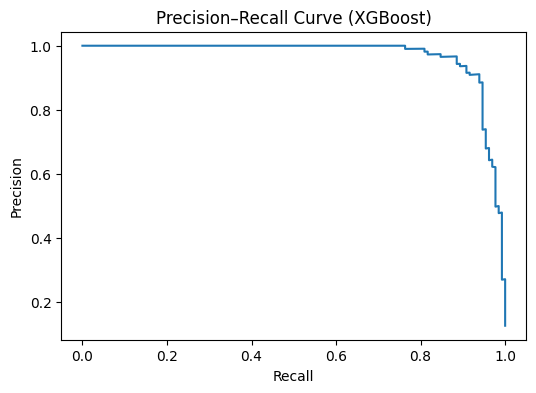

In [45]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

rows = []
for t in [0.3, 0.35, 0.4, 0.42, 0.45, 0.5]:
    y_pred_t = (y_probs >= t).astype(int)
    rpt = classification_report(y_test, y_pred_t, output_dict=True)
    rows.append({
        "threshold": t,
        "precision_spam": rpt["1"]["precision"],
        "recall_spam": rpt["1"]["recall"],
        "f1_spam": rpt["1"]["f1-score"]
    })

pd.DataFrame(rows)


,threshold,precision_spam,recall_spam,f1_spam
0,0.30,0.879433,0.946565,0.911765
1,0.35,0.891304,0.938931,0.914498
2,0.40,0.904412,0.938931,0.921348
3,0.42,0.911111,0.938931,0.924812
4,0.45,0.910448,0.931298,0.920755
5,0.50,0.909091,0.916031,0.912548


In [47]:
final_threshold = 0.42
y_pred_final = (y_probs >= final_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       903
           1       0.91      0.94      0.92       131

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [50]:
# Save alongside the model
final_threshold


0.42